In [1]:
!pip install scikit-image

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import morphology, io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_ubyte
import os

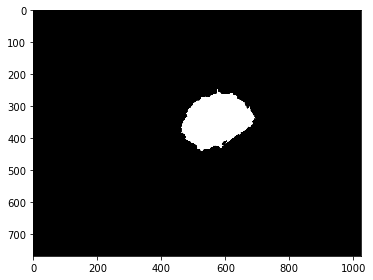

In [3]:
temp = plt.imread('../data/raw/example_segmentation/ISIC_0001769_segmentation.png')
temp_resized = resize(temp, (768, 1024),anti_aliasing=True)
            
io.imshow(img_as_ubyte(temp_resized))

In [4]:
#Resize all images to 768x1024 and output to interim
#for filename in os.listdir('../data/raw/example_segmentation'):
#    if 'DS' in filename: 
#        continue
#    temp = plt.imread('../data/raw/example_segmentation/'+filename)
#    temp_resized = resize(temp, (768, 1024),anti_aliasing=True)

#    new_filename = filename[:5]+"re_"+filename[5:]                 
#    io.imsave('../data/interim/resized_segments_ver_2/'+new_filename, img_as_ubyte(temp_resized), check_contrast = False)

In [5]:
im = plt.imread('../data/raw/example_image/ISIC_0003462.jpg')
mask=plt.imread('../data/raw/example_segmentation/ISIC_0003462_segmentation.png')


2.652473991139666 %


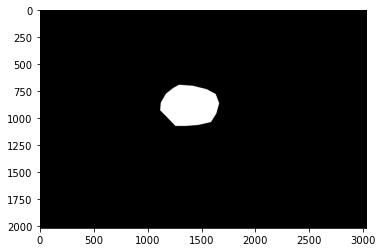

In [6]:
#Total size of the image
total = mask.shape[0] * mask.shape[1] 

#Size of mask only
area = np.sum(mask)

#As percentage
print(area/total*100, "%")
plt.imshow(mask, cmap='gray')

[[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]]
161705.0
159022


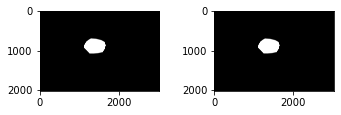

In [7]:
#Structural element, that we will use as a "brush" on our mask. The parameter is "brush size"
struct_el = morphology.disk(2)
print(struct_el)

# Use this "brush" to erode the image - eat away at the borders

mask_eroded = morphology.binary_erosion(mask, struct_el)

# Show side by side (depending on brush size, you might not see a difference visually)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify the new mask is smaller
new_area= np.sum(mask_eroded)

print(area)
print(new_area)

2683.0


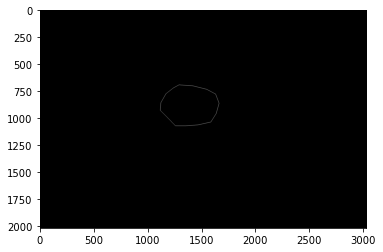

In [8]:
# Subtract the two masks from each other to get the border/perimeter

image_perimeter = mask - mask_eroded

plt.imshow(image_perimeter, cmap='gray') #Depending on the size of the "brush" it might be difficult to see on the screen

#What is the length of this perimeter = how many 1s? 
print(np.sum(image_perimeter))

{'r': 32172, 'g': 30766, 'b': 28373}


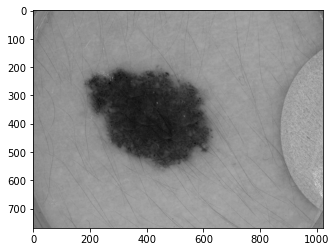

In [9]:
images = os.listdir('../data/interim/resized_images')
segments = os.listdir('../data/interim/resized_segments')
#Greyscaling
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

fim = plt.imread('../data/interim/resized_images/'+images[5])
fim_segment = plt.imread('../data/interim/resized_segments/'+segments[5])
gray = rgb2gray(fim)
plt.imshow(gray,cmap='gray')

# red test cases: 1, 15, 93, 23
# green test cases: 

colors = ("r", "g", "b")
ids = (0, 1, 2)

hist_data = {}
for c,id in zip(colors,ids):
    histogram, bin_edges = np.histogram(fim[:,:,id], bins = 256, range = (0,256))
    hist_data[c] = histogram
#print(hist_data)

dictionary = {}
for c in colors:
    dictionary[c] = np.max(hist_data[c])
print(dictionary)

In [10]:
#gray2 = gray[0:1500,:]
#plt.imshow(gray2, cmap='gray')

#mask2 = mask[0:1500,:]
#plt.imshow(mask2)

In [11]:
def q(im):
    hist_data = {}
    for c,id in zip(colors,ids):
        histogram, bin_edges = np.histogram(fim[:,:,id], bins = 256, range = (0,256))
        hist_data[c] = histogram
    #print(hist_data)

    dictionary = {c: np.max(hist_data[c]) for c in colors}
    #print(dictionary)
    
    max_pixel_count = max(dictionary.values())
    # if there are two maxes???
    quantile = 0
    
    ### i'll set the quantiles later after i test with a couple images

    if max_pixel_count == dictionary["r"]:
        # if b and g <<< r, then quantile = 0.5 fits much better --> test case 23
        ## quantile = 0.2 fits much better for test case 60 ??
        quantile = 0.3
    elif max_pixel_count == dictionary["g"]:
        quantile = 0.1
    else:
        quantile = 0.1
    
    return dictionary

print(q(fim))

{'r': 32172, 'g': 30766, 'b': 28373}


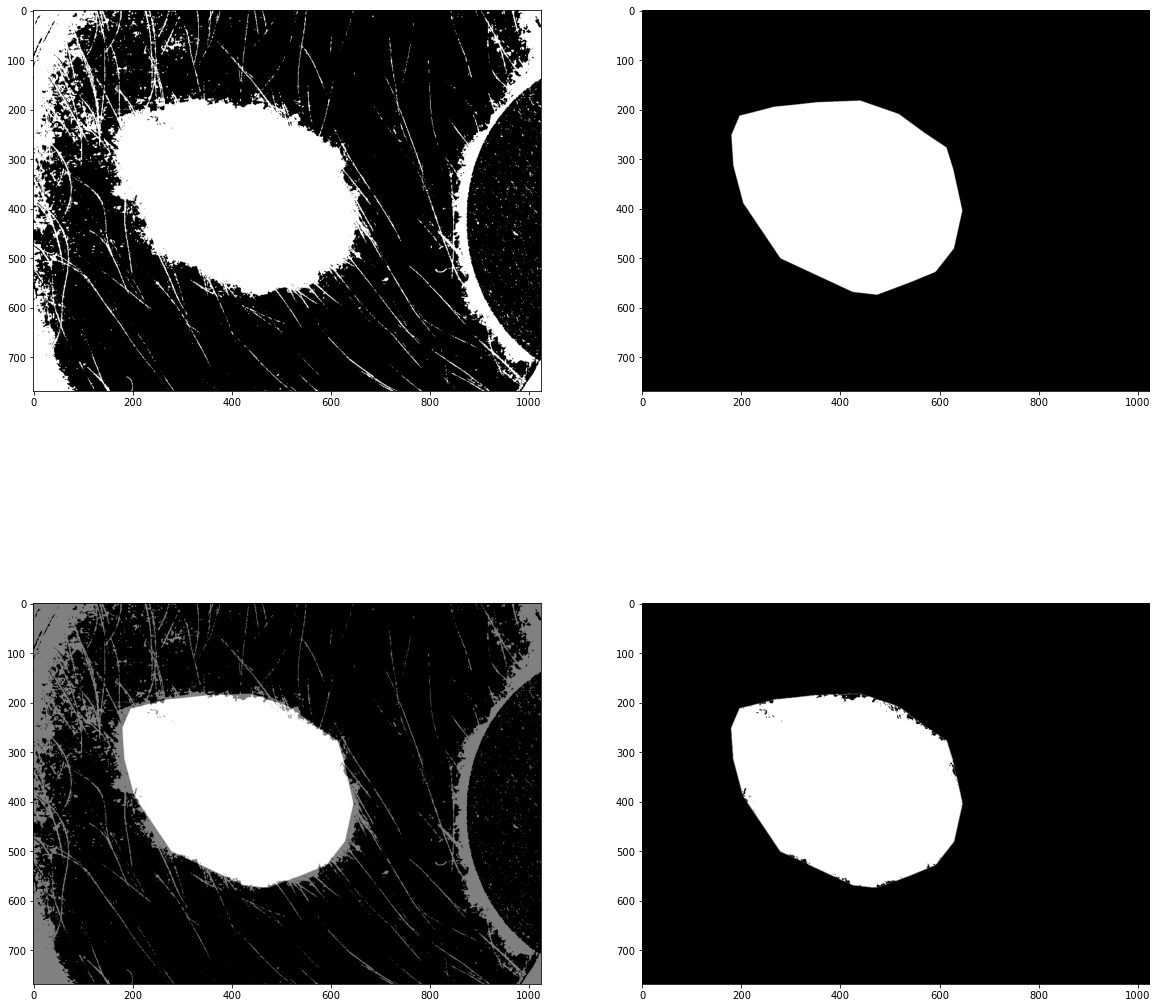

In [12]:
mymask = gray < np.quantile(gray,0.3) 

better_mask = mymask + fim_segment
fixed_mask = better_mask.copy()
fixed_mask[fixed_mask==1] = 0



f, ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].imshow(mymask,cmap='gray')
ax[0,1].imshow(fim_segment,cmap='gray')
ax[1,0].imshow(better_mask,cmap='gray')
ax[1,1].imshow(fixed_mask,cmap='gray')

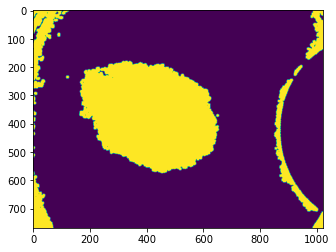

In [13]:
from skimage.morphology import opening

struct_el = morphology.disk(5)
opened = opening(mymask, struct_el)
plt.imshow(opened)

In [14]:
filenames = os.listdir('../data/interim/resized_images')
def crop(filename, left, right,upper, lower):
    to_crop = plt.imread('../data/interim/resized_images/'+filename)
    return to_crop[upper:lower,left:right,:]
    

(768, 1024, 3)


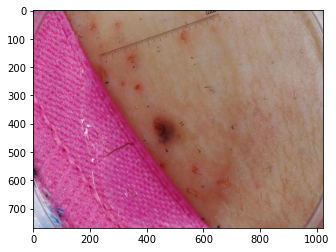

In [15]:
fil = filenames[28]
temp = plt.imread('../data/interim/resized_images/'+fil)
plt.imshow(temp)
print(temp.shape)
